In [1]:
!nvidia-smi

Fri Dec 30 11:09:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    N/A /  N/A |      0MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.is_built_with_cuda()
print(tf.version.VERSION)

2.6.0


In [6]:
import sys
sys.version

'3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]'

In [7]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [9]:
BASE_DIR = 'input/flickr8k'
WORKING_DIR = 'working'

In [10]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# # extract features from image
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

In [12]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [13]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [14]:
len(features)

8088

# Load Caption data

In [15]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(mapping)

8091

In [18]:
del mapping['1000268201_693b08cb0e']


In [19]:
del mapping['1001773457_577c3a7d70']

In [20]:
del mapping['1002674143_1b742ab4b8']

In [21]:
len(mapping)

8088

# Preprocessing

In [22]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [23]:
# # before preprocess of text
# mapping['1001773457_577c3a7d70']

In [24]:
# preprocess the text
clean(mapping)

In [25]:
# # after preprocess of text
# mapping['1001773457_577c3a7d70']

In [26]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [27]:
len(all_captions)

40440

In [28]:
all_captions[:10]

['startseq man lays on bench while his dog sits by him endseq',
 'startseq man lays on the bench to which white dog is also tied endseq',
 'startseq man sleeping on bench outside with white and black dog sitting next to him endseq',
 'startseq shirtless man lies on park bench with his dog endseq',
 'startseq man laying on bench holding leash of dog sitting on ground endseq',
 'startseq man in an orange hat starring at something endseq',
 'startseq man wears an orange hat and glasses endseq',
 'startseq man with gauges and glasses is wearing blitz hat endseq',
 'startseq man with glasses is wearing beer can crocheted hat endseq',
 'startseq the man with pierced ears is wearing glasses and an orange hat endseq']

In [29]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [30]:
vocab_size

8484

In [31]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# train test split

In [32]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [33]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [34]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [35]:
# # train the model
# epochs = 5
# batch_size = 64
# steps = len(train) // batch_size
# generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# generator

In [38]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 177s 777ms/step - loss: 1.9652


In [51]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [52]:
# model = tensorflow.keras.models.load_model(WORKING_DIR+'/best_model.h5')
# model = Model.load_model(WORKING_DIR+'/best_model.h5')
from tensorflow import keras
model = keras.models.load_model(WORKING_DIR+'/best_model.h5')

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      2171904     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [54]:
len(mapping['1003163366_44323f5815'][0])

59

# Generate Captions for the Image

In [55]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [56]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [57]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length) 
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)
    
# # calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# Visualize the Results

In [60]:
pip install pillow

     ---------------------------------------- 2.5/2.5 MB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 4.8 MB/s eta 0:00:00
     ------------------------------------- 161.3/161.3 kB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB 2.8 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     -------------------------------------- 965.4/965.4 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 98.3/98.3 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [63]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
startseq man in plaid shirt lays on the bench endseq


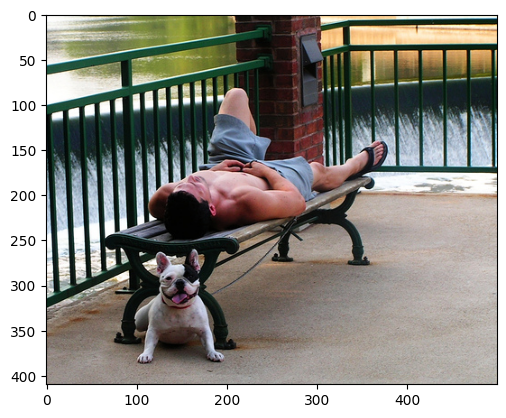

In [64]:
generate_caption("1003163366_44323f5815.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq skier is displaying pictures in the snow endseq


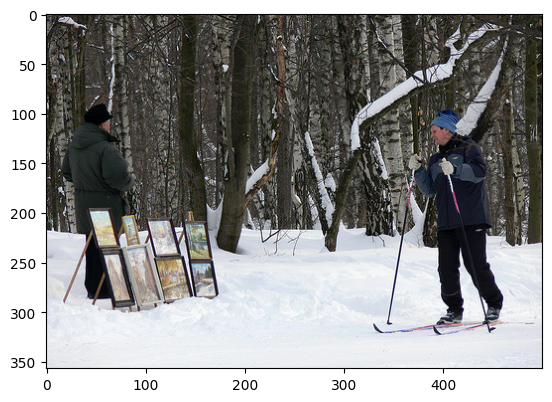

In [65]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
startseq man in plaid shirt lays on the bench endseq


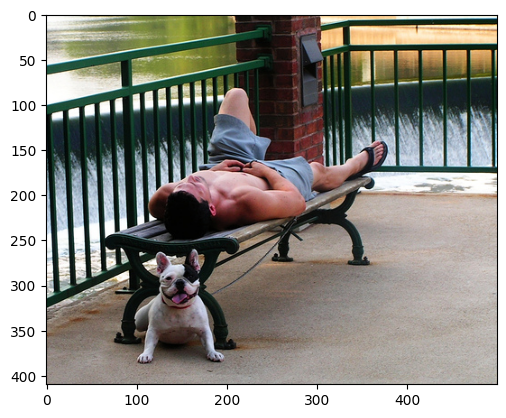

In [66]:
generate_caption("1003163366_44323f5815.jpg")